In [24]:
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [25]:
df = pd.read_csv('../../data/raw/Sentences_AllAgree.txt', header=None, names=["text", "label"], encoding="latin1", sep="@")

In [26]:
df.describe()

,text,label
count,2264,2264
unique,2259,3
top,SSH Communications Security Corporation is hea...,neutral
freq,2,1391


In [27]:
df.dropna()
df["text"] = df["text"].str.strip()
df["label"] = df["label"].str.strip()

In [28]:
df.describe()

,text,label
count,2264,2264
unique,2259,3
top,SSH Communications Security Corporation is hea...,neutral
freq,2,1391


In [29]:
df = df[df["label"] != "neutral"]

In [30]:
df.describe()

,text,label
count,873,873
unique,873,2
top,"For the last quarter of 2010 , Componenta 's n...",positive
freq,1,570


In [31]:
label_map = {
    "positive": 1,
    "negative": -1
}

df["label"] = df["label"].map(label_map)

In [32]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [33]:
df.head()

,text,label
0,Finnish electronics contract manufacturer Scan...,-1
1,"ADPnews - Jul 17 , 2009 - Finland-based steel ...",-1
2,According to Nordic financial group Nordea 's ...,1
3,"Cargo traffic fell 1 % year-on-year to 8,561 t...",-1
4,"However , sales volumes in the food industry a...",1


In [34]:
len(df[df['label']==-1])

303

In [35]:
len(df[df['label']==1])

570

In [36]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        lowercase=True,
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        stop_words='english'
    )),
    ("clf", LogisticRegression(max_iter=1000))
])
X = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
proba = pipeline.predict_proba(X_test)

In [45]:
proba_pos = pipeline.predict_proba(X_test)[:, 1]
proba_pos

array([0.52235672, 0.80581804, 0.72706198, 0.49921568, 0.6504162 ,
       0.58821581, 0.3613676 , 0.72248497, 0.79787111, 0.71693346,
       0.50754638, 0.75489521, 0.46147325, 0.56964017, 0.88498381,
       0.74130176, 0.47098289, 0.75620654, 0.74951596, 0.69938843,
       0.56303115, 0.75608286, 0.71913927, 0.79809172, 0.75861416,
       0.44958136, 0.76984495, 0.60941735, 0.33814643, 0.66421934,
       0.77507208, 0.61931477, 0.59164228, 0.81915085, 0.44830874,
       0.72041369, 0.762456  , 0.74667633, 0.73505791, 0.76641836,
       0.41613117, 0.71152724, 0.54342916, 0.80910606, 0.49232653,
       0.65182828, 0.7289291 , 0.45792176, 0.75872348, 0.35956002,
       0.62535016, 0.69352969, 0.81395203, 0.76987665, 0.77055999,
       0.61982391, 0.43844889, 0.5753601 , 0.66815344, 0.38591079,
       0.67685559, 0.77857238, 0.80623462, 0.59612644, 0.76312047,
       0.85959389, 0.65793714, 0.74249116, 0.8344386 , 0.66387162,
       0.55115659, 0.72883351, 0.49286319, 0.49498941, 0.80182

In [37]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, pred))

Accuracy: 0.7828571428571428


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))


Precision: 0.7638888888888888
Recall: 0.9649122807017544
F1: 0.8527131782945736


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

          -1       0.87      0.44      0.59        61
           1       0.76      0.96      0.85       114

    accuracy                           0.78       175
   macro avg       0.82      0.70      0.72       175
weighted avg       0.80      0.78      0.76       175



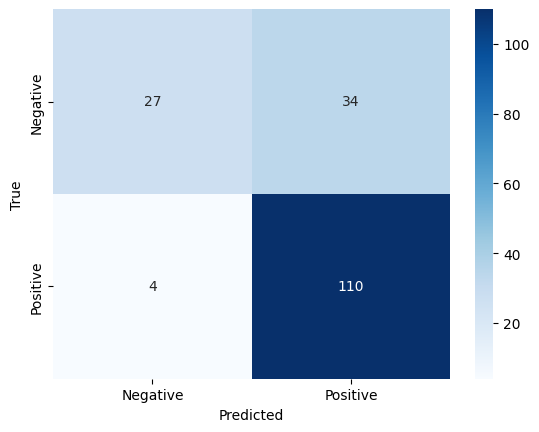

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [41]:
pred.shape

(175,)

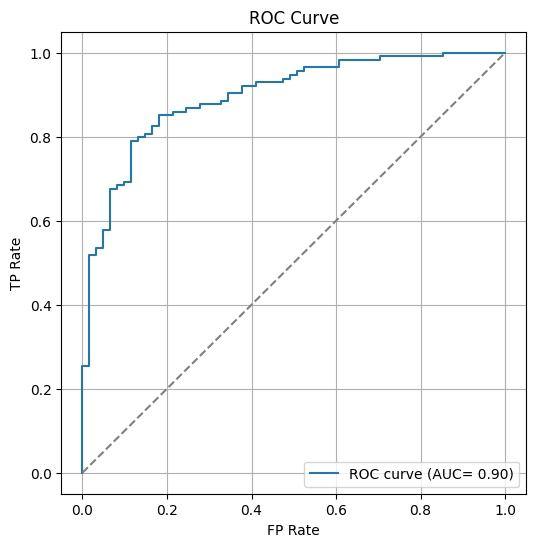

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, proba_pos)
auc = roc_auc_score(y_test, proba_pos)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC= {auc:.2f})")
plt.plot([0, 1], [0,1], linestyle="--", color="gray")
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
text = "Apple shares jump after strong earnings beat."
pred = pipeline.predict([text])[0]              # -> 0/1 label
proba = pipeline.predict_proba([text])[0][1]    # -> P(positive) if 1 is positive
print(pred, proba)


1 0.657797005536902


In [ ]:
def trace_pipeline(pipeline, text, top_k=10):
    tfidf = pipeline.named_steps["tfidf"]
    clf   = pipeline.named_steps["clf"]

    an = tfidf.build_analyzer()
    print("TOKENS:", an(text)[:50])

    X = tfidf.transform([text])
    feature_names = tfidf.get_feature_names_out()
    w = clf.coef_[0]; b = clf.intercept_[0]

    # tf-idf values
    row = X.tocoo()
    print("\nNON-ZERO TF-IDF FEATURES:")
    for _, j, v in zip(row.row, row.col, row.data):
        print(f"{feature_names[j]:<30} tfidf={v:.4f}")

    # score & probability
    import numpy as np
    z = X.multiply(w).sum() + b
    p = 1 / (1 + np.exp(-z))
    print(f"\nLOGREG: z={z:.4f}, p(positive)={p:.4f}")

    # contributions
    contrib = X.multiply(w).toarray()[0]
    nz = np.nonzero(contrib)[0]
    top_idx = nz[np.argsort(np.abs(contrib[nz]))[::-1][:top_k]]
    print("\nTOP CONTRIBUTIONS (signed):")
    for j in top_idx:
        sign = "+" if contrib[j] >= 0 else ""
        print(f"{feature_names[j]:<30} {sign}{contrib[j]:.4f}")


In [ ]:
trace_pipeline(pipeline, "IREN (IREN) Surges on Transition to AI Service")


TOKENS: ['iren', 'iren', 'surges', 'transition', 'ai', 'service', 'iren iren', 'iren surges', 'surges transition', 'transition ai', 'ai service']

NON-ZERO TF-IDF FEATURES:
service                        tfidf=1.0000

LOGREG: z=0.9714, p(positive)=0.7254

TOP CONTRIBUTIONS (signed):
service                        +0.1725


In [ ]:
corpus = [

    'This is the first document.',

    'This document is the second document.',

    'And this is the third one.',

    'Is this the first document?',

]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21 stored elements and shape (4, 9)>
  Coords	Values
  (0, 8)	0.38408524091481494
  (0, 3)	0.38408524091481494
  (0, 6)	0.38408524091481494
  (0, 2)	0.580285823684436
  (0, 1)	0.4697913855799205
  (1, 8)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 6)	0.281088674033753
  (1, 1)	0.6876235979836938
  (1, 5)	0.5386476208856763
  (2, 8)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 6)	0.267103787642168
  (2, 0)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 4)	0.511848512707169
  (3, 8)	0.38408524091481494
  (3, 3)	0.38408524091481494
  (3, 6)	0.38408524091481494
  (3, 2)	0.580285823684436
  (3, 1)	0.4697913855799205
